#

In [5]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

DATA_PATH_TRAIN = '../bds/TSLA.csv'

In [6]:
TSLA = pd.read_csv(DATA_PATH_TRAIN, sep=',')


# TESTE DE HOMOGENEIDADE

### CONCEITOS GERAIS

**DEFINIÇÃO:** O teste de homogeneidade é um teste que verifica se uma determinada variável se distribui da mesma forma em várias diferentes outras amostras de interesse. 

De maneira análoga, podemos definir de outra maneira:

**DEFINIÇÃO MATEMÁTICA:** Seja $X_1, X_2, ..., X_n$ uma amostra da população $P_x$ com uma distribuição de probabilidade $F_x(x)$, e $Y_1, Y_2, ..., Y_n$ uma amostra da população $P_y$ com uma distribuição de probabilidade $F_y(y)$.

Queremos verificar com o teste de homogeneidade que $F_x(x)$ = $F_y(y)$. Bata aplicar um teste de hipótese, onde a hipótese nula ($H_0$) que assumir que as distribuições $F_x(x)$ e $F_y(y)$ são identicas, e que a hipótese alternativa ($H_a$) não são idênticas.

Isto é:

$$ H_0: F_X(x) = F_Y(x) $$

$$ H_a: F_X(x) \neq F_Y(x) $$

Podemos vazer esse estudo com base no **teste qui-quadrado de Pearson**, onde poderemos determinar se aceitamos ou rejeitamos a nossa hipótese nula ($H_0$). Para esse teste, devemos ter nossos dados divididos em categorias. Ou seja, é um teste estatítisco aplicado a dados categóricos.

Para aplicar o **teste qui-quadrado de Pearson** e análisar o teste de hipótese que definimos devemos seguir os seguintes passos:
- Calcular a nossa estatística $\chi^2$, dada por:
$$
\chi^2 = \sum_{i=1}^{nº classes} \sum_{j=1}^{nº amostras} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$
$O_{ij}$ é a frequência observada na célula $ (i,j) $ da tabela de contingência.

$E_{ij}$ é a frequência esperada na célula $ (i,j) $. As frequências esperadas são calculadas com base na hipótese nula e na distribuição proporcional dos dados.


- Determinar os nossos graus de liberdade, onde é dado por gl = (Amostras - 1)(Classes - 1)
- Selecionar o nível de significância ($\alpha$), geralmente é assumido 5% ou 1%. O nível de significância corresponde ao erro do tipo I.
- Compara $\chi^2$ com o seu valor critico $\chi^{2}_{crítico}$, computacionalmente é usado bilbiotecas para isso enquanto que manualmente recorre-se para tabelas da distribuição qui-quadrado.
- Se $\chi^{2}$>$\chi^{2}_{crítico}$ iremos rejeitar ($H_0$), senão aceitamos ($H_0$).

![Tabela qui-quadrado](../images/tabela-qui-quadrado.jpg)

### CONCEITOS APLICADOS

Vamos estudar se há relação em preferência a um sabor de sorvete em diferentes cidades.

**Nosso objetivo é:** Queremos saber se a preferência por diferentes sabores de sorvete varia entre três cidades.

Os dados que usaremos abaixo são fictícios:

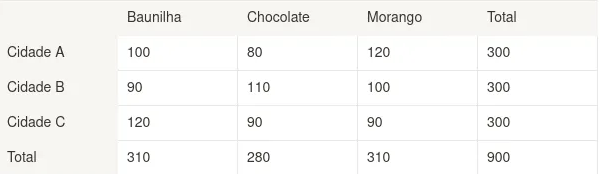

Famos organizar as nossas hipóteses:

$$HIPÓTESE\space NULA (H_0): Não\space há\space preferência\space de\space sorvete\space entre\space as\space populações$$

$$HIPÓTESE \space ALTERNATIVA (H_a): Há\space preferência\space de\space sorvete\space entre\space as\space populações$$

Ao fazer o estudo, com o teste qui-quadrado, devemos calcular a tabela de frequências esperadas:

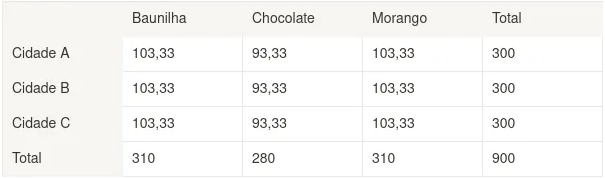

Nosso grau de liberdade nessa caso é de $$gl=(3-1)(3-1)=4$$

Usaremos, como nosso nível de significância $$\alpha = 5 \% =0,05$$

Com esse nível de significância e esse grau de liberdade, na tabela que vimos anteriosmente vamos ter que: $\chi^{2}_{crítico}=9,488$

In [7]:
from scipy.stats import chi2_contingency,chi2, chisquare

# Dados organizados em uma matriz (tabela de contingência)
dados = np.array([
    [100, 80, 120],
    [90, 110, 100],
    [120, 90, 90]
])

# Executar o teste qui-quadrado de homogeneidade
qui_quadrado, p_valor, graus_liberdade, _ = chi2_contingency(dados)

# Imprimir os resultados
print("Qui-Quadrado:", qui_quadrado)
print("Valor-p:", p_valor)
print("Graus de Liberdade:", graus_liberdade)

# Definir o nível de significância (alpha)
alpha = 0.05

# Comparar o valor de qui-quadrado calculado com o valor crítico
valor_critico = chi2.ppf(1 - alpha, graus_liberdade)
print("Valor Crítico:", valor_critico)

# Testar a hipótese nula
if qui_quadrado > valor_critico:
    print("Rejeita a hipótese nula: Os grupos não são homogêneos.")
else:
    print("Não rejeita a hipótese nula: Os grupos são homogêneos.")

Qui-Quadrado: 14.032258064516128
Valor-p: 0.0071928097972273715
Graus de Liberdade: 4
Valor Crítico: 9.487729036781154
Rejeita a hipótese nula: Os grupos não são homogêneos.


# TESTE DE ASSOCIAÇÃO

### CONCEITOS GERAIS

**DEFINIÇÃO:** Um teste de associação _(comumente chamada de teste de independência)_ faz o estudo de duas variáveis, querendo identificar se elas são associadas ou se são independentes. Quando aplicado, o teste indica se a relação observada entre as variáveis é significativa ou se ocorreu apenas por acaso.

O teste de associação/independência é comumente usada com o teste qui-quadrado, equação vista anteriormente.

O teste de associação basea-se na hipótese nula **($H_0$)** de que as variáveis são independentes, ou seja, que a distribuição conjunta das variáveis é o produto das suas distribuições marginais.

Sejam **$X$** e **$Y$** duas variáveis. **($H_0$)** afirma que **$X$** e **$Y$** são idependentes, ou seja, que para todos $i$ e $j$ possíveis de **$X$** e **$Y$**:

$$P(X=x_i,Y=y_i)=P(X=x_i)P(y=y_i)$$

Ou seja, a probabilidade conjunta de $X$ e $Y$ ser igual a $x_i$ e $y_j$, respectivamente, deve ser igual ao produto das probabilidades individuais de $X = x_i$ e $Y = y_j$. O teste de associação mede o grau em que as frequências observadas divergem dessas frequências esperadas sob a hipótese de independência.



Para aplicar o teste de associação devemos seguir os seguintes passos:

##### 1. Formule as Hipóteses
- **Hipótese Nula ($H_0$)**: As variáveis são independentes, ou seja, não há associação entre elas.
- **Hipótese Alternativa ($H_A$)**: Existe uma associação entre as variáveis, ou seja, elas não são independentes.

##### 2. Construa a Tabela de Contingência
Crie uma tabela de contingência com as frequências observadas para cada combinação das categorias das variáveis. Suponha uma tabela de $r$ linhas e $c$ colunas. Seja $O_{ij}$ o valor observado na célula da linha $i$ e coluna $j$.

##### 3. Calcule as Frequências Esperadas
Sob a hipótese de independência, as frequências esperadas para cada célula da tabela são calculadas pela fórmula:

$$
E_{ij} = \frac{N_{i\cdot} \cdot N_{\cdot j}}{N}
$$

Onde:
- $E_{ij}$ é a frequência esperada na célula $(i,j)$,
- $N_{i\cdot}$ é o total da linha $i$,
- $N_{\cdot j}$ é o total da coluna $j$,
- $N$ é o total geral da tabela.

##### 4. Calcule a Estatística Qui-Quadrado
A estatística qui-quadrado é dada pela fórmula:

$$
\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$

Onde:
- $O_{ij}$ é a frequência observada na célula $(i,j)$,
- $E_{ij}$ é a frequência esperada na célula $(i,j)$,
- $r$ é o número de linhas,
- $c$ é o número de colunas.

##### 5. Determine os Graus de Liberdade
Os graus de liberdade ($gl$) são calculados pela fórmula:

$$
gl = (r - 1)(c - 1)
$$

Onde:
- $r$ é o número de linhas,
- $c$ é o número de colunas.

##### 6. Compare com o Valor Crítico
Compare o valor calculado de $\chi^2$ com o valor crítico da distribuição qui-quadrado com $gl$ graus de liberdade e um nível de significância $\alpha$ (tipicamente $\alpha = 0.05$).

- Se $\chi^2_{\text{calculado}} > \chi^2_{\text{crítico}}$, rejeitamos $H_0$ (há associação).
- Se $\chi^2_{\text{calculado}} \leq \chi^2_{\text{crítico}}$, não rejeitamos $H_0$ (não há associação).


### CONCEITOS APLICADOS

No exemplo aplicado, queremos fazer o estudo de associação na preferência de marcas de refrigerantes entre homens e mulheres, em um grupo de pessoas.

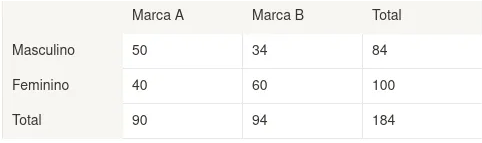

Para isso vamos aplicar teste de hipótese, que seguem como foram apresentadas:

$$
(H_0): O \space gênero\space e\space a\space preferência\space por\space marcas\space são\space independentes\space
$$
$$
(H_a): O\space gênero\space e\space a\space preferência\space por\space marcas\space são\space dependentes\space (Têm\space associação)
$$

Criando a nossa tabela de frequência esperadas, com base no nosso **($H_0$)** vamos ter que:

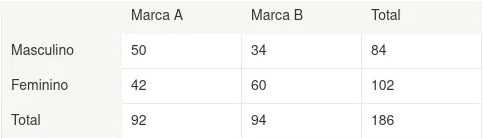

Nosso grau de liberdade nessa caso é de $$gl=(2-1)(2-1)=1$$

Usaremos, como nosso nível de significância $$\alpha = 5 \% =0,05$$

Com esse nível de significância e esse grau de liberdade, na tabela que vimos anteriosmente vamos ter que: $\chi^{2}_{crítico}=3,841$

Vamos fazer o restante dos cálculos no Python:

In [8]:
observed_data = np.array([[50, 34], 
                          [42, 60]])

# Realize o teste de independência
qui_quadrado, p, graus_liberdade, _ = chi2_contingency(observed_data)

alpha = 0.05
# Determinando o valor crítico 
valor_critico = chi2.ppf(1 - alpha, graus_liberdade)

# Imprima o valor do Qui-Quadrado, crítico e o valor p
print("Qui-Quadrado:", qui_quadrado)
print("Valor crítico:", valor_critico)
print("Valor p:", p)

# Avalie a significância estatística
if p < alpha:
    print("H0 rejeitada. Há uma associação significativa entre gênero e preferência por marca.")
else:
    print("H0 não rejeitada. Não há evidência suficiente para afirmar uma associação significativa.")


Qui-Quadrado: 5.491034260605262
Valor crítico: 3.841458820694124
Valor p: 0.019114232513214174
H0 rejeitada. Há uma associação significativa entre gênero e preferência por marca.


# REFERÊNCIAS

Ventura, M. (2023, September 25). **Teste qui-quadrado: Uma ferramenta essencial para análise de dados categóricos: Exemplos e aplicações em Python.** Medium. https://medium.com/@matheusventura/teste-qui-quadrado-a95cb5ba8c66

Busta, J., & Morretin, L. (2022). **Estatística básica (9. ed.)**. Editora XYZ.

Samejima, K. MATD49 - **Estatística Não Paramétrica: Testes de Qui-quadrado**. Instituto de Matemática e Estatística, Universidade Federal da Bahia (IME-UFBA).

# OUTROS EXEMPLOS PRÁTICOS

### HOMOGENEIDADE

### ASSOCIAÇÃO